# 라이브러리 불러오기

In [102]:
import pandas as pd
pd.set_option("display.max_column", None)
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings(action='ignore')
sns.set()

# 데이터 불러오기

In [103]:
cus = pd.read_csv("open/cus_info.csv")
iem = pd.read_csv("open/iem_info_20210902.csv")
hist = pd.read_csv("open/stk_bnc_hist.csv")

train = pd.read_csv("open/stk_hld_train.csv")
test = pd.read_csv("open/stk_hld_test.csv")
sub = pd.read_csv("open/sample_submission.csv")

# EDA

In [104]:
cus.shape, iem.shape, hist.shape

((10000, 10), (3079, 5), (2573839, 6))

In [105]:
train.shape, test.shape, sub.shape

((681472, 4), (70596, 6), (70596, 2))

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681472 entries, 0 to 681471
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   act_id  681472 non-null  object
 1   iem_cd  681472 non-null  object
 2   byn_dt  681472 non-null  int64 
 3   hold_d  681472 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 20.8+ MB


In [107]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   submit_id  70596 non-null  object
 1   hold_d     70596 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [108]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   act_id     70596 non-null  object
 1   iem_cd     70596 non-null  object
 2   byn_dt     70596 non-null  int64 
 3   hist_d     70596 non-null  int64 
 4   submit_id  70596 non-null  object
 5   hold_d     70596 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.2+ MB


In [109]:
cus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   act_id             10000 non-null  object
 1   sex_dit_cd         10000 non-null  int64 
 2   cus_age_stn_cd     10000 non-null  int64 
 3   ivs_icn_cd         10000 non-null  int64 
 4   cus_aet_stn_cd     10000 non-null  int64 
 5   mrz_pdt_tp_sgm_cd  10000 non-null  int64 
 6   lsg_sgm_cd         10000 non-null  int64 
 7   tco_cus_grd_cd     10000 non-null  int64 
 8   tot_ivs_te_sgm_cd  10000 non-null  int64 
 9   mrz_btp_dit_cd     10000 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 781.4+ KB


In [110]:
iem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079 entries, 0 to 3078
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   iem_cd                3079 non-null   object
 1   iem_krl_nm            3079 non-null   object
 2   btp_cfc_cd            3079 non-null   int64 
 3   mkt_pr_tal_scl_tp_cd  3079 non-null   int64 
 4   stk_dit_cd            3079 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 120.4+ KB


In [111]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573839 entries, 0 to 2573838
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   act_id       object 
 1   bse_dt       int64  
 2   iem_cd       object 
 3   bnc_qty      float64
 4   tot_aet_amt  float64
 5   stk_par_pr   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 117.8+ MB


# 데이터 전처리

## train['hist_d']

In [112]:
train['hist_d'] = train['hold_d']*0.7
train['hist_d'] = np.trunc(train['hist_d'])

In [113]:
train.head()

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,5.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,40.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,2.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,11.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,162.0


## LifeStage 데이터 수정

In [114]:
pd.crosstab(cus['sex_dit_cd'], cus['lsg_sgm_cd'])

lsg_sgm_cd,2,3,4,5,6,7,8,9
sex_dit_cd,,,,,,,,
1,1100,1926,0,1905,3,827,0,224
2,760,0,1164,688,848,0,400,155


In [115]:
# life stage 데이터 수정
cus['sex_dit_cd'][ (cus['sex_dit_cd']==1) & (cus['lsg_sgm_cd']==6) ] = 2
cus['sex_dit_cd'][ (cus['sex_dit_cd']==2) & (cus['lsg_sgm_cd']==5) ] = 1

In [116]:
pd.crosstab(cus['sex_dit_cd'], cus['lsg_sgm_cd'])

lsg_sgm_cd,2,3,4,5,6,7,8,9
sex_dit_cd,,,,,,,,
1,1100,1926,0,2593,0,827,0,224
2,760,0,1164,0,851,0,400,155


## 결측처리(서비스등급)

In [117]:
# 서비스 등급 결측치(99)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 1)] = 3 # 1억 이상, 3억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 2)] = 3 # 1억 이상, 3억 미만

# 서비스 등급 미정의(9)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 1)] = 9 # 1천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 2)] = 5 # 1천 이상, 3천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 3)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 4)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 5)] = 3 # 1억 이상, 3억 미만

# 이외의 서비스 등급 미정의(9)는 고객등급 6으로 설정
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9)] = 6

In [118]:
train = pd.merge(train, cus, how = "left", on = ["act_id"])
train = pd.merge(train, iem, how = "left", on = ["iem_cd"])

test = pd.merge(test, cus, how = "left", on = ["act_id"])
test = pd.merge(test, iem, how = "left", on = ["iem_cd"])

In [119]:
train.shape, test.shape, sub.shape

((681472, 18), (70596, 19), (70596, 2))

## merge(train, hist)

In [120]:
train = pd.merge(train, hist, how = "left", on = ["act_id", "iem_cd"])
test = pd.merge(test, hist, how = "left", on = ["act_id", "iem_cd"])

### 매수일자 == 기준일자 

In [121]:
train = train[(train["byn_dt"] == train["bse_dt"])]
train.reset_index(drop = True, inplace = True)
test = test[(test["byn_dt"] == test["bse_dt"])]
test.reset_index(drop = True, inplace = True)

In [122]:
train.shape, test.shape, sub.shape

((681472, 22), (70596, 23), (70596, 2))

## 상관분석

<AxesSubplot:>

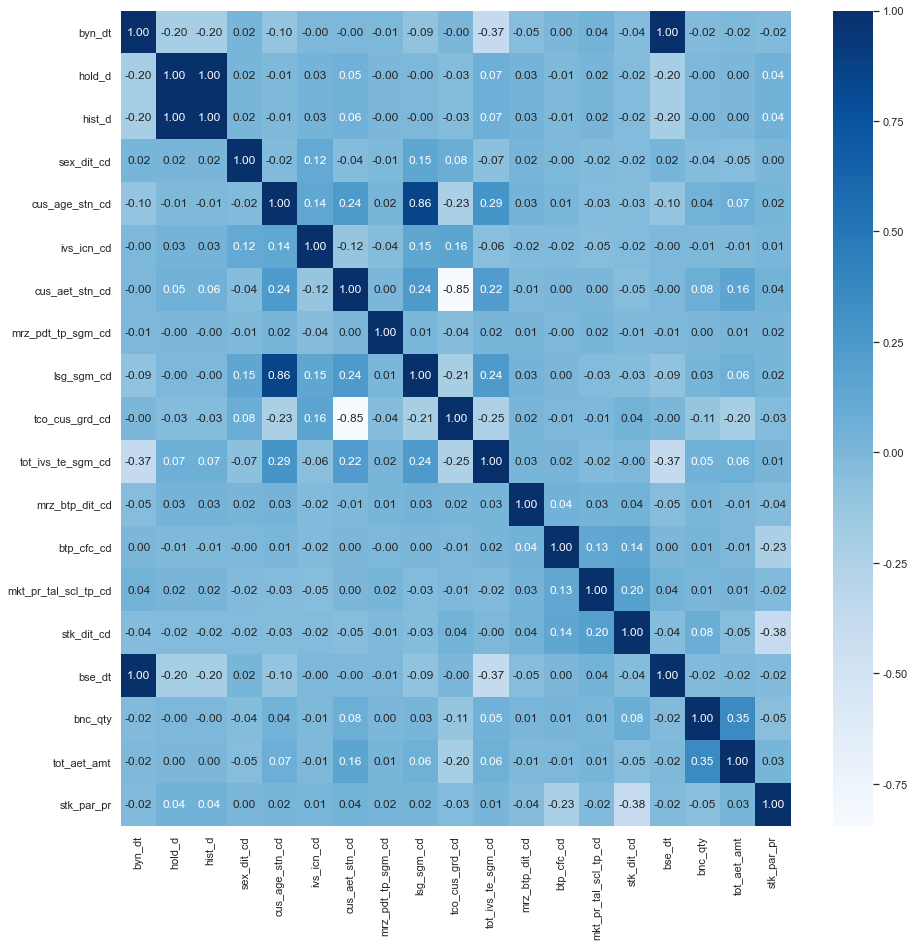

In [123]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap='Blues')

## 삭제할 컬럼 
- iem_cd: 종목명이랑 겹쳐서 drop
- ivs_icn_cd: 주관적인 컬럼이라 drop
- mrz_pdt_tp_sgm_cd: 대부분 국내주식이기에 의미없는 컬럼이라 drop
- bse_dt, byn_dt: year, month 컬럼 만들어서 drop
- stk_par_pr: 액면가 drop
- sex_dit_cd : lifestage에 성별 있어서 drop

In [124]:
drop_cols = ['iem_cd', 'ivs_icn_cd', 'mrz_pdt_tp_sgm_cd', 'stk_par_pr', 'bse_dt', 'sex_dit_cd'] # , 'lsg_sgm_cd' // iem_krl_nm or iem_cd 'byn_dt',
for col in drop_cols:
    train.drop(col, axis=1, inplace= True)
    test.drop(col, axis=1, inplace= True)

In [125]:
test = test.drop('submit_id', axis=1)

In [126]:
train.columns, test.columns

(Index(['act_id', 'byn_dt', 'hold_d', 'hist_d', 'cus_age_stn_cd',
        'cus_aet_stn_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd',
        'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd',
        'stk_dit_cd', 'bnc_qty', 'tot_aet_amt'],
       dtype='object'),
 Index(['act_id', 'byn_dt', 'hist_d', 'hold_d', 'cus_age_stn_cd',
        'cus_aet_stn_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd',
        'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd',
        'stk_dit_cd', 'bnc_qty', 'tot_aet_amt'],
       dtype='object'))

## LabelEncoder

In [127]:
for col in train.columns:
    if train[col].dtypes == 'object':
        print(col)

act_id
iem_krl_nm


In [128]:
encoder = LabelEncoder()
encoder.fit(iem['iem_krl_nm'])
train['iem_krl_nm'] = encoder.transform(train['iem_krl_nm'])
test['iem_krl_nm'] = encoder.transform(test['iem_krl_nm'])

In [129]:
encoder = LabelEncoder()
encoder.fit(cus['act_id'])
train['act_id'] = encoder.transform(train['act_id'])
test['act_id'] = encoder.transform(test['act_id'])

## PCA(LifeStage & 연령대)

In [130]:
train[['cus_age_stn_cd','lsg_sgm_cd']].head()

,cus_age_stn_cd,lsg_sgm_cd
0,9,9
1,9,9
2,9,9
3,9,9
4,9,9


In [131]:
pca = PCA(n_components=1)
pca.fit(train[['cus_age_stn_cd','lsg_sgm_cd']])
train['PCA_age_lsg'] = pca.transform(train[['cus_age_stn_cd','lsg_sgm_cd']])
pca.fit(test[['cus_age_stn_cd','lsg_sgm_cd']])
test['PCA_age_lsg'] = pca.transform(test[['cus_age_stn_cd','lsg_sgm_cd']])

print(pca.explained_variance_ratio_)

[0.93193502]


In [132]:
train['PCA_age_lsg']

0         5.563337
1         5.563337
2         5.563337
3         5.563337
4         5.563337
            ...   
681467   -2.178993
681468   -2.178993
681469   -2.178993
681470   -2.178993
681471   -2.178993
Name: PCA_age_lsg, Length: 681472, dtype: float64

In [133]:
train.drop(['cus_age_stn_cd','lsg_sgm_cd'], axis=1, inplace=True)
test.drop(['cus_age_stn_cd','lsg_sgm_cd'], axis=1, inplace=True)

## PCA(자산구간 & 서비스등급)

In [134]:
train[['cus_aet_stn_cd','tco_cus_grd_cd']].head()

,cus_aet_stn_cd,tco_cus_grd_cd
0,2,5
1,2,5
2,2,5
3,2,5
4,2,5


In [135]:
pca = PCA(n_components=1)
pca.fit(train[['cus_aet_stn_cd','tco_cus_grd_cd']])
train['PCA_cus'] = pca.transform(train[['cus_aet_stn_cd','tco_cus_grd_cd']])
pca.fit(test[['cus_aet_stn_cd','tco_cus_grd_cd']])
test['PCA_cus'] = pca.transform(test[['cus_aet_stn_cd','tco_cus_grd_cd']])

print(pca.explained_variance_ratio_)

[0.94850782]


In [136]:
train['PCA_cus']

0        -1.085031
1        -1.085031
2        -1.085031
3        -1.085031
4        -1.085031
            ...   
681467   -0.488011
681468   -0.488011
681469   -0.488011
681470   -0.488011
681471   -0.488011
Name: PCA_cus, Length: 681472, dtype: float64

In [137]:
train.drop(['cus_aet_stn_cd','tco_cus_grd_cd'], axis=1, inplace=True)
test.drop(['cus_aet_stn_cd','tco_cus_grd_cd'], axis=1, inplace=True)

## 스케일링(RobustScaler)

In [138]:
scaler_cols = train.drop('hold_d', axis=1).columns
scaler_cols

Index(['act_id', 'byn_dt', 'hist_d', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd',
       'iem_krl_nm', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd',
       'bnc_qty', 'tot_aet_amt', 'PCA_age_lsg', 'PCA_cus'],
      dtype='object')

In [139]:
scaler = RobustScaler()

for col in scaler_cols:
    scaler.fit(np.array(train[col]).reshape(-1,1))
    train[col] = scaler.transform(np.array(train[col]).reshape(-1,1))
    test[col] = scaler.transform(np.array(test[col]).reshape(-1,1))

scaler_train = train
scaler_test = test

scaler_train['hold_d'] = np.log1p(scaler_train['hold_d'])
scaler_test['hold_d'] = np.log1p(scaler_test['hold_d'])

In [140]:
scaler_train

,act_id,byn_dt,hold_d,hist_d,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,PCA_age_lsg,PCA_cus
0,-0.825979,-1.930301,2.484907,0.428571,2.0,-0.666667,-1.096168,-1.500000,-0.5,-1.010309,0.917012,4.213264,1.189954,-0.271191
1,-0.825979,-1.988629,4.394449,5.428571,2.0,-0.666667,-0.185105,-0.166667,-0.5,-1.010309,-0.211618,1.586814,1.189954,-0.271191
2,-0.825979,-1.950789,1.791759,0.000000,2.0,-0.666667,0.660159,0.333333,0.0,0.000000,3.041494,5.310557,1.189954,-0.271191
3,-0.825979,0.068131,3.135494,1.285714,2.0,-0.666667,0.254519,-0.333333,0.0,-1.010309,0.029046,-0.164153,1.189954,-0.271191
4,-0.825979,-1.912754,5.783825,22.857143,2.0,-0.666667,0.057122,0.000000,0.5,0.000000,0.539419,2.799188,1.189954,-0.271191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,-0.388718,-1.920008,0.693147,-0.285714,0.0,-0.666667,0.097614,0.000000,0.5,0.000000,0.605809,1.023105,-0.662009,0.000000
681468,-0.388718,0.059798,0.693147,-0.285714,0.0,-0.666667,0.525669,-0.333333,0.0,0.000000,1.804979,8.535924,-0.662009,0.000000
681469,-0.388718,-1.891579,0.693147,-0.285714,0.0,-0.666667,-0.792480,-1.333333,0.0,0.000000,8.950207,3.216609,-0.662009,0.000000
681470,-0.388718,-0.019900,0.693147,-0.285714,0.0,-0.666667,0.609544,-1.333333,0.5,0.000000,0.962656,0.709687,-0.662009,0.000000


In [141]:
scaler_train.shape, scaler_test.shape, sub.shape

((681472, 14), (70596, 14), (70596, 2))

## hold_d drop

In [142]:
train_label = scaler_train["hold_d"]
scaler_train.drop(["hold_d"], axis = 1, inplace = True)

# 모델 학습: CatBoostRegressor 사용

## CatBoostRegressor

In [143]:
models = []

kfold = KFold(n_splits=10)
for train_idx, val_idx in kfold.split(scaler_train):
    
    X_train = scaler_train.iloc[train_idx, :]
    y_train = train_label[train_idx]
    X_val = scaler_train.iloc[val_idx, :]
    y_val = train_label[val_idx]


    model = CatBoostRegressor(iterations=None,
                            learning_rate=0.03,
                            depth=2,
                            l2_leaf_reg=None,
                            model_size_reg=None,
                            use_best_model=True,
                            rsm=None,
                            loss_function='RMSE')
    
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=500)

    models.append(model)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.2274186	test: 1.3033188	best: 1.3033188 (0)	total: 154ms	remaining: 2m 33s
500:	learn: 0.0730650	test: 0.0724915	best: 0.0724915 (500)	total: 1m 20s	remaining: 1m 20s
999:	learn: 0.0729798	test: 0.0723874	best: 0.0723874 (999)	total: 2m 18s	remaining: 0us

bestTest = 0.07238736171
bestIteration = 999

0:	learn: 1.2235243	test: 1.3364153	best: 1.3364153 (0)	total: 121ms	remaining: 2m
500:	learn: 0.0730511	test: 0.0721260	best: 0.0721260 (500)	total: 1m 9s	remaining: 1m 9s
999:	learn: 0.0729837	test: 0.0720713	best: 0.0720712 (998)	total: 2m 17s	remaining: 0us

bestTest = 0.07207122671
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 1.2215918	test: 1.3525845	best: 1.3525845 (0)	total: 144ms	remaining: 2m 23s
500:	learn: 0.0731288	test: 0.0711449	best: 0.0711449 (500)	total: 1m 13s	remaining: 1m 12s
999:	learn: 0.0730733	test: 0.0710994	best: 0.0710994 (999)	total: 2m 49s	remaining: 0us

bestTest = 0.07109936145
bestIteration = 999

0:	learn: 1.2285067	tes

# 결과추론

In [144]:
result = []
for i in models:
    result.append(i.predict(scaler_test.drop('hold_d', axis = 1)))
pred = np.mean(result, axis = 0)

In [145]:
pred

array([5.72604885, 6.50637807, 5.63486191, ..., 6.69396816, 3.15593676,
       2.21458529])

In [146]:
pred = np.expm1(pred)
pred

array([305.75483613, 668.39751373, 279.02024657, ..., 806.52027455,
        22.47501727,   8.15761059])

In [147]:
len(pred)

70596

In [148]:
sub["hold_d"] = np.round(pred)

# 결과물 평가

In [149]:
test = pd.read_csv('open/stk_hld_test.csv')

In [150]:
test_sub = pd.merge(test.drop('hold_d', axis=1), sub, how='left', on='submit_id')
upper = test_sub['hist_d'] >= test_sub['hold_d']           
under = ((test_sub['hold_d'] - test_sub['hist_d']) > 146)  
test_sub[upper | under]

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,306.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,668.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,472.0
9,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A009580,20181206,510,IDX00010,792.0
11,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,A000030,20160104,1227,IDX00012,872.0
...,...,...,...,...,...,...
70579,4e90d4001683b20b87ec3ca828db0e360acb58dd1be858...,A058220,20200319,195,IDX70580,390.0
70580,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A117580,20160104,1227,IDX70581,867.0
70587,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A033780,20191105,287,IDX70588,573.0
70588,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A017670,20190723,357,IDX70589,710.0


## upper case(hist_d + 146)

In [151]:
upper_idx = test_sub[upper].index.tolist()
len(upper_idx)

220

In [152]:
sub.loc[upper_idx, 'hold_d'] = test_sub.loc[upper_idx, 'hist_d'] + 146

In [153]:
sub.head()

,submit_id,hold_d
0,IDX00001,306.0
1,IDX00002,668.0
2,IDX00003,279.0
3,IDX00004,472.0
4,IDX00005,18.0


## under case(hist_d + 1)

In [154]:
under_idx = test_sub[under].index.tolist()
len(under_idx)

13588

In [155]:
sub.loc[under_idx, 'hold_d'] = test_sub.loc[under_idx, 'hist_d'] + 1

In [156]:
sub.head()

,submit_id,hold_d
0,IDX00001,154.0
1,IDX00002,336.0
2,IDX00003,279.0
3,IDX00004,237.0
4,IDX00005,18.0


In [157]:
sub.to_csv('result/after1.csv', index = False)